In [15]:
import torch, os, psutil
print("CUDA available:", torch.cuda.is_available())
print("PyTorch CUDA:", torch.version.cuda)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0),
          "| VRAM(GB):", round(torch.cuda.get_device_properties(0).total_memory/1e9,2))
print("Threads:", os.cpu_count(), "| Physical cores:", psutil.cpu_count(logical=False))
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True


CUDA available: True
PyTorch CUDA: 11.8
GPU: NVIDIA GeForce RTX 3090 | VRAM(GB): 25.77
Threads: 20 | Physical cores: 12


In [16]:
import random, numpy as np, torch

# CSVs (columns: image_path,label)
TRAIN_CSV = r"C:\K2452367\Dissertation\Deepfakedetection_masters_2025\FF++(HQ)\FF++(HQ)_CSV\combined_training_original_cross_data_full_with_augmentation.csv"
VAL_CSV   = r"C:\K2452367\Dissertation\Deepfakedetection_masters_2025\FF++(HQ)\FF++(HQ)_CSV\combined_validation_original_cross_data_full_with_augmentation.csv"
TEST_CSV  = r"C:\K2452367\Dissertation\Deepfakedetection_masters_2025\FF++(HQ)\FF++(HQ)_CSV\combined_testing_original_cross_data_full_with_augmentation.csv"

DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE  = 8
NUM_EPOCHS  = 10
NUM_WORKERS = 0        # Windows-safe; try 4–8 later if stable
CKPT_DIR    = "checkpoints"
RESUME      = True     # resume if latest.pt exists


# Training hyperparams
LR           = 1e-4           
WEIGHT_DECAY = 0.05           
LORA_RANK    = 16             
LORA_ALPHA   = 32             
LORA_DROPOUT = 0.10           
WARMUP_RATIO = 0.10           


# Early stopping (on Val Loss)
EARLY_PATIENCE   = 3
EARLY_MIN_DELTA  = 1e-4

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
set_seed(42)

os.makedirs(CKPT_DIR, exist_ok=True)
print("Device:", DEVICE)


Device: cuda


In [17]:
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image, ImageFile
from torchvision import transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True

CLIP_MEAN = (0.48145466, 0.4578275, 0.40821073)
CLIP_STD  = (0.26862954, 0.26130258, 0.27577711)

class DeepfakeDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file); self.transform = transform
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        for _ in range(3):
            row = self.data.iloc[idx]
            p, y = row["path"], int(row["label"])
            try:
                img = Image.open(p).convert("RGB")
                if self.transform: img = self.transform(img)
                return img, y
            except Exception:
                idx = np.random.randint(0, len(self.data))
        import torch
        return torch.zeros(3,224,224), 0

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize(CLIP_MEAN, CLIP_STD),
])
eval_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(CLIP_MEAN, CLIP_STD),
])
print("Transforms & dataset class ready.")


Transforms & dataset class ready.


In [18]:
from torch.utils.data import DataLoader

train_ds = DeepfakeDataset(TRAIN_CSV, transform=train_tfms)
val_ds   = DeepfakeDataset(VAL_CSV,   transform=eval_tfms)
test_ds  = DeepfakeDataset(TEST_CSV,  transform=eval_tfms)

dl_args = dict(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)
train_loader = DataLoader(train_ds, shuffle=True,  **dl_args)
val_loader   = DataLoader(val_ds,   shuffle=False, **dl_args)
test_loader  = DataLoader(test_ds,  shuffle=False, **dl_args)

xb, yb = next(iter(train_loader))
print(f"Probe batch: {xb.shape}, labels: {len(yb)}")
print(f"Sizes — train:{len(train_ds)} val:{len(val_ds)} test:{len(test_ds)}")


Probe batch: torch.Size([8, 3, 224, 224]), labels: 8
Sizes — train:171686 val:33472 test:33295


In [19]:
import torch.nn as nn
from transformers import CLIPModel

def build_vision_encoder():
    clip = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
    return clip.vision_model  # CLIPVisionModel

class DeepfakeClassifier(nn.Module):
    def __init__(self, vision_encoder, embed_dim=768, num_classes=2):
        super().__init__()
        self.vision_encoder = vision_encoder
        self.proj = nn.Linear(vision_encoder.config.hidden_size, embed_dim)
        self.cls  = nn.Linear(embed_dim, num_classes)
    def forward(self, x):
        out = self.vision_encoder(pixel_values=x)  # correct HF arg
        feat = self.proj(out.pooler_output)
        return self.cls(feat)

print("Model builders ready.")


Model builders ready.


In [20]:
import math, torch
from transformers.models.clip.modeling_clip import CLIPAttention

class LoRALinear(nn.Module):
    def __init__(self, base: nn.Linear, r: int, alpha: int, dropout: float):
        super().__init__()
        self.base = base
        for p in self.base.parameters(): p.requires_grad = False
        in_f, out_f = base.in_features, base.out_features
        self.lora_A = nn.Linear(in_f, r, bias=False)
        self.lora_B = nn.Linear(r, out_f, bias=False)
        nn.init.kaiming_uniform_(self.lora_A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B.weight)
        self.scaling = alpha / float(r)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        y = self.base(x)
        return y + self.scaling * self.lora_B(self.lora_A(self.drop(x))).to(y.dtype)

def apply_lora_to_encoder(vision_encoder, r=4, alpha=32, dropout=0.1):
    n = 0
    for m in vision_encoder.modules():
        if isinstance(m, CLIPAttention):
            m.q_proj   = LoRALinear(m.q_proj,   r, alpha, dropout)
            m.k_proj   = LoRALinear(m.k_proj,   r, alpha, dropout)
            m.v_proj   = LoRALinear(m.v_proj,   r, alpha, dropout)
            m.out_proj = LoRALinear(m.out_proj, r, alpha, dropout)
            n += 1
    print(f"LoRA applied to {n} attention blocks.")


In [21]:
def count_trainable_params(model):
    t = sum(p.numel() for p in model.parameters())
    tr = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable: {tr:,} / {t:,} ({100*tr/t:.2f}%)")

enc = build_vision_encoder()
for p in enc.parameters(): p.requires_grad = False
apply_lora_to_encoder(enc, r=LORA_RANK, alpha=LORA_ALPHA, dropout=LORA_DROPOUT)

model = DeepfakeClassifier(enc).to(DEVICE)
count_trainable_params(model)


LoRA applied to 24 attention blocks.
Trainable: 3,934,466 / 307,114,242 (1.28%)


In [22]:
def print_param_counts(model):
    total = sum(p.numel() for p in model.parameters())
    train = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = total - train
    print(f"Total params:     {total:,}")
    print(f"Trainable params: {train:,} ({train/total*100:.2f}%)")
    print(f"Frozen params:    {frozen:,} ({frozen/total*100:.2f}%)")

print_param_counts(model)


Total params:     307,114,242
Trainable params: 3,934,466 (1.28%)
Frozen params:    303,179,776 (98.72%)


In [23]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.amp import GradScaler, autocast

criterion = nn.CrossEntropyLoss()

def compute_metrics(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    try: auc = roc_auc_score(y_true, y_prob)
    except: auc = 0.0
    return acc, f1, auc

def create_cosine_with_warmup(optimizer, total_steps, warmup_ratio=0.1, min_lr=0.0):
    warm = max(1, int(total_steps * warmup_ratio))
    def lr_lambda(step):
        if step < warm: return step / float(max(1, warm))
        prog = (step - warm) / float(max(1, total_steps - warm))
        return max(min_lr, 0.5 * (1.0 + math.cos(math.pi * prog)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
total_steps = max(1, len(train_loader)) * NUM_EPOCHS
scheduler  = create_cosine_with_warmup(optimizer, total_steps, warmup_ratio=WARMUP_RATIO)
scaler     = GradScaler(device="cuda" if DEVICE=="cuda" else "cpu")
print("Optim, scaler, scheduler ready.")


Optim, scaler, scheduler ready.


In [24]:
from tqdm import tqdm

def train_one_epoch(epoch, model, loader, optimizer, scheduler, scaler):
    model.train(); tot, ys, yh, yp = 0.0, [], [], []
    for imgs, labels in tqdm(loader, desc=f"Epoch {epoch} [Train]"):
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = torch.as_tensor(labels, device=DEVICE)
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda", enabled=(DEVICE=="cuda")):
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update(); scheduler.step()
        tot += loss.item() * imgs.size(0)
        probs = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        preds = logits.argmax(1).detach().cpu().numpy()
        ys.extend(labels.detach().cpu().numpy()); yh.extend(preds); yp.extend(probs)
    avg = tot / len(loader.dataset); acc,f1,auc = compute_metrics(ys,yh,yp)
    print(f"[Train] Ep{epoch:02d} | Loss {avg:.4f} | Acc {acc:.4f} | F1 {f1:.4f} | AUROC {auc:.4f}")
    return avg, acc, f1, auc

def validate(epoch, model, loader):
    model.eval(); tot, ys, yh, yp = 0.0, [], [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            labels = torch.as_tensor(labels, device=DEVICE)
            with autocast(device_type="cuda", enabled=(DEVICE=="cuda")):
                logits = model(imgs)
                loss = criterion(logits, labels)
            tot += loss.item() * imgs.size(0)
            probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            preds = logits.argmax(1).cpu().numpy()
            ys.extend(labels.cpu().numpy()); yh.extend(preds); yp.extend(probs)
    avg = tot / len(loader.dataset); acc,f1,auc = compute_metrics(ys,yh,yp)
    print(f"[Val]   Ep{epoch:02d} | Loss {avg:.4f} | Acc {acc:.4f} | F1 {f1:.4f} | AUROC {auc:.4f}")
    return avg, acc, f1, auc


In [25]:
import os, torch

def save_ckpt(state, name):
    torch.save(state, os.path.join(CKPT_DIR, name))

def load_ckpt(model, optimizer, scheduler, scaler, name="latest.pt"):
    path = os.path.join(CKPT_DIR, name)
    if not os.path.exists(path): return model, optimizer, scheduler, scaler, 1, 0.0, float("inf"), 0, False
    ckpt = torch.load(path, map_location=DEVICE)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    scheduler.load_state_dict(ckpt["scheduler"])
    scaler.load_state_dict(ckpt["scaler"])
    start_epoch = ckpt["epoch"] + 1
    best_auc    = ckpt.get("best_auc", 0.0)
    best_loss   = ckpt.get("best_loss", float("inf"))
    es_bad      = ckpt.get("early_bad", 0)
    return model, optimizer, scheduler, scaler, start_epoch, best_auc, best_loss, es_bad, True

class EarlyStopper:
    def __init__(self, patience=3, min_delta=1e-4, mode='min'):
        self.patience = patience; self.min_delta = min_delta; self.mode = mode
        self.best = float('inf') if mode=='min' else -float('inf')
        self.bad = 0
    def step(self, value):
        if self.mode == 'min':
            improved = value < self.best - self.min_delta
        else:
            improved = value > self.best + self.min_delta
        if improved:
            self.best = value; self.bad = 0; return False
        self.bad += 1
        return self.bad >= self.patience


In [26]:
# Early stopping on Val Loss; best model saved by Val AUROC
early = EarlyStopper(patience=EARLY_PATIENCE, min_delta=EARLY_MIN_DELTA, mode='min')
start_epoch, best_auc, best_loss, es_bad = 1, 0.0, float("inf"), 0

if RESUME:
    model, optimizer, scheduler, scaler, start_epoch, best_auc, best_loss, es_bad, ok = load_ckpt(
        model, optimizer, scheduler, scaler, "latest.pt"
    )
    if ok:
        early.best = best_loss; early.bad = es_bad
        print(f"Resumed from epoch {start_epoch-1} | best_auc={best_auc:.4f} | best_loss={best_loss:.4f}")
    else:
        print("No checkpoint found; fresh start.")
else:
    print("Fresh start (RESUME=False).")

for epoch in range(start_epoch, NUM_EPOCHS+1):
    _ = train_one_epoch(epoch, model, train_loader, optimizer, scheduler, scaler)
    val_loss, val_acc, val_f1, val_auc = validate(epoch, model, val_loader)

    # Save latest (with early stopper state)
    save_ckpt({
        "epoch": epoch, "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "scaler": scaler.state_dict(),
        "best_auc": best_auc,
        "best_loss": min(best_loss, val_loss),
        "early_bad": early.bad
    }, "latest.pt")

    # Save best-by-AUROC model
    if val_auc > best_auc:
        best_auc = val_auc
        save_ckpt({
            "epoch": epoch, "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "scaler": scaler.state_dict(),
            "best_auc": best_auc,
            "best_loss": min(best_loss, val_loss),
            "early_bad": early.bad
        }, "best_by_auc.pt")
        print(f"💾 Best-by-AUROC updated (Val AUROC {val_auc:.4f})")

    # Track best loss (for info / resume)
    if val_loss < best_loss:
        best_loss = val_loss

    # Early stopping on Val Loss
    if early.step(val_loss):
        print(f"⏹️ Early stopping at epoch {epoch} (best Val Loss {early.best:.4f}).")
        break

print("✅ Training finished.")


No checkpoint found; fresh start.


Epoch 1 [Train]: 100%|█████████████████████████████████████████████████████████| 21461/21461 [1:47:59<00:00,  3.31it/s]


[Train] Ep01 | Loss 0.1216 | Acc 0.9470 | F1 0.9474 | AUROC 0.9909
[Val]   Ep01 | Loss 0.0921 | Acc 0.9666 | F1 0.9657 | AUROC 0.9965
💾 Best-by-AUROC updated (Val AUROC 0.9965)


Epoch 2 [Train]: 100%|█████████████████████████████████████████████████████████| 21461/21461 [1:42:34<00:00,  3.49it/s]


[Train] Ep02 | Loss 0.0531 | Acc 0.9797 | F1 0.9797 | AUROC 0.9982
[Val]   Ep02 | Loss 0.0883 | Acc 0.9713 | F1 0.9707 | AUROC 0.9962


Epoch 3 [Train]: 100%|█████████████████████████████████████████████████████████| 21461/21461 [1:40:12<00:00,  3.57it/s]


[Train] Ep03 | Loss 0.0404 | Acc 0.9850 | F1 0.9850 | AUROC 0.9989
[Val]   Ep03 | Loss 0.1100 | Acc 0.9667 | F1 0.9658 | AUROC 0.9965


Epoch 4 [Train]: 100%|█████████████████████████████████████████████████████████| 21461/21461 [1:38:28<00:00,  3.63it/s]


[Train] Ep04 | Loss 0.0323 | Acc 0.9876 | F1 0.9876 | AUROC 0.9993
[Val]   Ep04 | Loss 0.0641 | Acc 0.9769 | F1 0.9768 | AUROC 0.9979
💾 Best-by-AUROC updated (Val AUROC 0.9979)


Epoch 5 [Train]: 100%|█████████████████████████████████████████████████████████| 21461/21461 [1:35:26<00:00,  3.75it/s]


[Train] Ep05 | Loss 0.0254 | Acc 0.9901 | F1 0.9901 | AUROC 0.9996
[Val]   Ep05 | Loss 0.0937 | Acc 0.9757 | F1 0.9754 | AUROC 0.9978


Epoch 6 [Train]: 100%|█████████████████████████████████████████████████████████| 21461/21461 [1:32:18<00:00,  3.87it/s]


[Train] Ep06 | Loss 0.0191 | Acc 0.9928 | F1 0.9928 | AUROC 0.9998
[Val]   Ep06 | Loss 0.0906 | Acc 0.9742 | F1 0.9743 | AUROC 0.9974


Epoch 7 [Train]: 100%|█████████████████████████████████████████████████████████| 21461/21461 [1:39:38<00:00,  3.59it/s]


[Train] Ep07 | Loss 0.0126 | Acc 0.9951 | F1 0.9951 | AUROC 0.9999
[Val]   Ep07 | Loss 0.1072 | Acc 0.9778 | F1 0.9775 | AUROC 0.9978
⏹️ Early stopping at epoch 7 (best Val Loss 0.0641).
✅ Training finished.


Loaded best_by_auc.pt

Classification Report:
              precision    recall  f1-score   support

           0     0.9703    0.9773    0.9738     16676
           1     0.9770    0.9700    0.9735     16619

    accuracy                         0.9736     33295
   macro avg     0.9737    0.9736    0.9736     33295
weighted avg     0.9737    0.9736    0.9736     33295


Confusion Matrix:
 [[16297   379]
 [  499 16120]]

AUROC: 0.9972


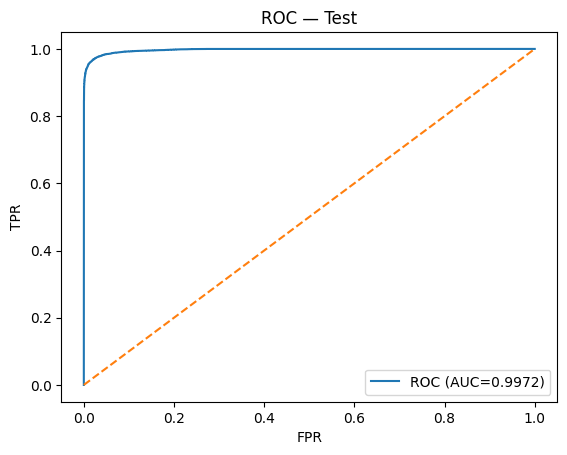

In [27]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

best_path = os.path.join(CKPT_DIR, "best_by_auc.pt")
if os.path.exists(best_path):
    state = torch.load(best_path, map_location=DEVICE)
    model.load_state_dict(state["model"])
    print("Loaded best_by_auc.pt")
else:
    print("best_by_auc.pt not found; using current weights.")

model.eval(); ys, yh, yp = [], [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        preds = logits.argmax(1).cpu().numpy()
        ys.extend(labels); yh.extend(preds); yp.extend(probs)

print("\nClassification Report:")
print(classification_report(ys, yh, digits=4))
cm = confusion_matrix(ys, yh)
print("\nConfusion Matrix:\n", cm)

fpr, tpr, _ = roc_curve(ys, np.array(yp))
roc_auc = auc(fpr, tpr)
print(f"\nAUROC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — Test")
plt.legend(loc="lower right"); plt.show()



--- Testing best model on held-out FF++ test set ---
Loaded best_by_auc.pt

Classification Report:
              precision    recall  f1-score   support

           0     0.9703    0.9773    0.9738     16676
           1     0.9770    0.9700    0.9735     16619

    accuracy                         0.9736     33295
   macro avg     0.9737    0.9736    0.9736     33295
weighted avg     0.9737    0.9736    0.9736     33295


Confusion Matrix:
 [[16297   379]
 [  499 16120]]

AUROC: 0.9972


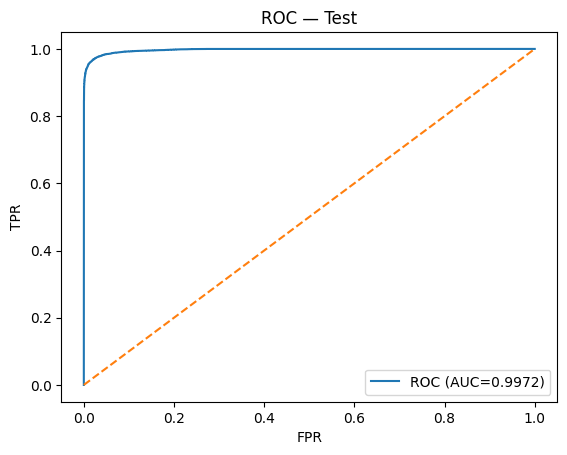

In [28]:
# 16) MAIN TEST — Test Best Model on Hold-out Set
# ────────────────────────────────────────────────────────────
print("\n--- Testing best model on held-out FF++ test set ---")
best_path = os.path.join(CKPT_DIR, "best_by_auc.pt")
if os.path.exists(best_path):
    state = torch.load(best_path, map_location=DEVICE)
    model.load_state_dict(state["model"])
    print("Loaded best_by_auc.pt")
else:
    print("best_by_auc.pt not found; using current weights.")

model.eval(); ys, yh, yp = [], [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        preds = logits.argmax(1).cpu().numpy()
        ys.extend(labels); yh.extend(preds); yp.extend(probs)

print("\nClassification Report:")
print(classification_report(ys, yh, digits=4))
cm = confusion_matrix(ys, yh)
print("\nConfusion Matrix:\n", cm)

fpr, tpr, _ = roc_curve(ys, np.array(yp))
roc_auc = auc(fpr, tpr)
print(f"\nAUROC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — Test")
plt.legend(loc="lower right"); plt.show()





--- Testing on CelebDF ---

Classification Report:
              precision    recall  f1-score   support

           0     0.6012    0.4711    0.5283      5258
           1     0.7493    0.8350    0.7898      9956

    accuracy                         0.7092     15214
   macro avg     0.6753    0.6530    0.6590     15214
weighted avg     0.6981    0.7092    0.6994     15214


Confusion Matrix:
 [[2477 2781]
 [1643 8313]]

AUROC: 0.7363


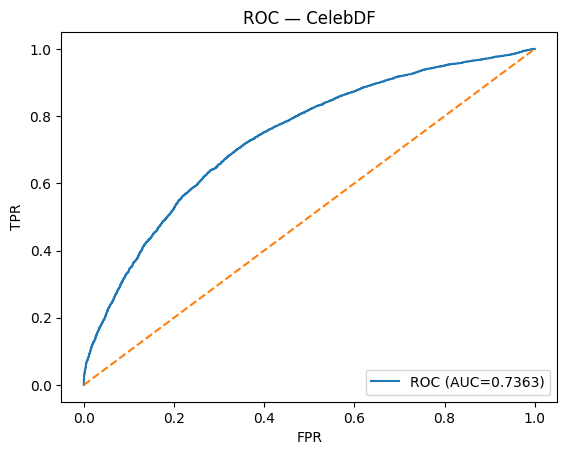

In [29]:
# 17) CelebDF Test Set
# ──────────────────────────────────────────────
CELEB_CSV = r"C:\\K2452367\\Dissertation\\Deepfakedetection_masters_2025\\celebdf_v2\\celeb_df_output_file.csv"
celeb_ds = DeepfakeDataset(CELEB_CSV, transform=eval_tfms)
celeb_loader = DataLoader(celeb_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS)

print("\n--- Testing on CelebDF ---")
model.eval(); ys, yh, yp = [], [], []
with torch.no_grad():
    for imgs, labels in celeb_loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        preds = logits.argmax(1).cpu().numpy()
        ys.extend(labels); yh.extend(preds); yp.extend(probs)

print("\nClassification Report:")
print(classification_report(ys, yh, digits=4))
cm = confusion_matrix(ys, yh)
print("\nConfusion Matrix:\n", cm)

fpr, tpr, _ = roc_curve(ys, np.array(yp))
roc_auc = auc(fpr, tpr)
print(f"\nAUROC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — CelebDF")
plt.legend(loc="lower right"); plt.show()





--- Testing on WildDeepfake ---

Classification Report:
              precision    recall  f1-score   support

           0     0.7286    0.6196    0.6697     36279
           1     0.6631    0.7644    0.7102     35541

    accuracy                         0.6913     71820
   macro avg     0.6959    0.6920    0.6899     71820
weighted avg     0.6962    0.6913    0.6897     71820


Confusion Matrix:
 [[22478 13801]
 [ 8372 27169]]

AUROC: 0.7873


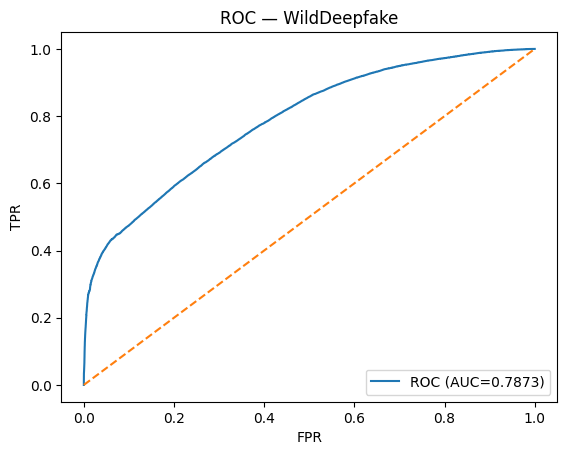

In [30]:
# 18) WildDeepfake Test Set
# ──────────────────────────────────────────────
WILD_CSV = r"C:\\K2452367\\Dissertation\\Deepfakedetection_masters_2025\\wilddeepfake\\wilddeepfake_test.csv"
wild_ds = DeepfakeDataset(WILD_CSV, transform=eval_tfms)
wild_loader = DataLoader(wild_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS)

print("\n--- Testing on WildDeepfake ---")
model.eval(); ys, yh, yp = [], [], []
with torch.no_grad():
    for imgs, labels in wild_loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        logits = model(imgs)
        probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
        preds = logits.argmax(1).cpu().numpy()
        ys.extend(labels); yh.extend(preds); yp.extend(probs)

print("\nClassification Report:")
print(classification_report(ys, yh, digits=4))
cm = confusion_matrix(ys, yh)
print("\nConfusion Matrix:\n", cm)

fpr, tpr, _ = roc_curve(ys, np.array(yp))
roc_auc = auc(fpr, tpr)
print(f"\nAUROC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — WildDeepfake")
plt.legend(loc="lower right"); plt.show()


In [31]:
# 22) Grad-CAM Visualization for Vision Model (No LORA)
# ──────────────────────────────────────────────────────────────────────────────
class GradCAM_CLIP:
    def __init__(self, model):
        self.model = model.eval()

    def _forward_and_get_grad(self, image_tensor, label=None):
        image_tensor = image_tensor.unsqueeze(0).to(DEVICE).requires_grad_(True)

        # Forward
        logits = self.model(image_tensor)
        probs = torch.softmax(logits, dim=1)
        pred_label = logits.argmax(dim=1).item()

        target_label = pred_label if label is None else label
        loss = probs[0, target_label]

        self.model.zero_grad()
        loss.backward()

        # Get gradients w.r.t. input image
        gradients = image_tensor.grad.detach().abs().mean(dim=1)[0].cpu().numpy()
        return gradients, pred_label, float(probs[0, pred_label])

    def generate_overlay(self, pil_img, saliency_map):
        saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min() + 1e-8)
        heatmap = (plt.cm.jet(saliency_map)[..., :3] * 255).astype(np.uint8)
        heatmap_img = Image.fromarray(heatmap).resize(pil_img.size, resample=Image.BILINEAR)
        overlay = Image.blend(pil_img.convert("RGBA"), heatmap_img.convert("RGBA"), alpha=0.4)
        return overlay


In [32]:
# Display Grad-CAM overlays from any dataset
from torchvision.transforms.functional import to_pil_image

def show_gradcam_examples(loader, model, dataset_name="Test Set", num_images=8):
    cam = GradCAM_CLIP(model)
    count = 0
    rows = max(1, num_images // 4)
    cols = min(4, num_images)

    plt.figure(figsize=(4 * cols, 3 * rows))
    for imgs, labels in loader:
        for img, label in zip(imgs, labels):
            if count >= num_images:
                break
            try:
                saliency, pred, conf = cam._forward_and_get_grad(img, label)
                pil_img = to_pil_image(img.cpu() * torch.tensor(CLIP_STD)[:, None, None] + torch.tensor(CLIP_MEAN)[:, None, None])
                overlay = cam.generate_overlay(pil_img, saliency)
            except Exception as e:
                print("GradCAM failed:", e)
                continue
            plt.subplot(rows, cols, count + 1)
            plt.imshow(overlay)
            plt.axis("off")
            plt.title(f"GT:{'Real' if label==0 else 'Fake'} | Pred:{'Real' if pred==0 else 'Fake'}\nConf:{conf:.2f}")
            count += 1
        if count >= num_images:
            break
    plt.suptitle(f"Grad-CAM (CLIP-based Vision Model): {dataset_name}", fontsize=14)
    plt.tight_layout()
    plt.show()
